In [1]:
from deel.lip.layers import (
    SpectralDense,
    SpectralConv2D,
    ScaledL2NormPooling2D,
    FrobeniusDense,
)
from deel.lip.model import Sequential
from deel.lip.activations import GroupSort
from deel.lip.losses import MulticlassHKR, MulticlassKR
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np
import tensorflow as tf

In [2]:
# load data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# standardize and reshape the data
x_train = np.expand_dims(x_train, -1)
mean = x_train.mean()
std = x_train.std()
x_train = (x_train - mean) / std
x_test = np.expand_dims(x_test, -1)
x_test = (x_test - mean) / std
# one hot encode the labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [3]:
model = Sequential(
    [
        Input(shape=(28, 28, 1)),
        # Lipschitz layers preserve the API of their superclass ( here Conv2D )
        # an optional param is available: k_coef_lip which control the lipschitz
        # constant of the layer
        SpectralConv2D(
            filters=16,
            kernel_size=(3, 3),
            activation=GroupSort(2),
            use_bias=True,
            kernel_initializer="orthogonal",
        ),
        # usual pooling layer are implemented (avg, max...), but new layers are also available
        ScaledL2NormPooling2D(pool_size=(2, 2), data_format="channels_last"),
        SpectralConv2D(
            filters=16,
            kernel_size=(3, 3),
            activation=GroupSort(2),
            use_bias=True,
            kernel_initializer="orthogonal",
        ),
        ScaledL2NormPooling2D(pool_size=(2, 2), data_format="channels_last"),
        # our layers are fully interoperable with existing keras layers
        Flatten(),
        SpectralDense(
            32,
            activation=GroupSort(2),
            use_bias=True,
            kernel_initializer="orthogonal",
        ),
        SpectralDense(
            32,
            activation=GroupSort(2),
            use_bias=True,
            kernel_initializer="orthogonal",
        ),
    ],
    # similary model has a parameter to set the lipschitz constant
    # to set automatically the constant of each layer
    k_coef_lip=1.0,
    name="hkr_model",
)
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

/home/lbethune/anaconda3/envs/tf2/lib/python3.8/site-packages/deel/lip/model.py:54: UserWarning: Sequential model contains a layer wich is not a Lipschitz layer: flatten
  warn(


In [8]:
batch_size = 128
buffer_size = 1024
ds = tf.data.Dataset.from_tensor_slices(x_train).repeat().shuffle(buffer_size).batch(batch_size)
num_steps = 300

In [9]:
import tqdm

def train(model, opt, ds):
    losses = []
    with tqdm.tqdm(total=num_steps) as pb:
        for step, batch in zip(range(num_steps), ds):
            with tf.GradientTape() as tape:
                z = model(batch, training=True)
                z1 = tf.expand_dims(z, axis=0)
                z2 = tf.expand_dims(z, axis=1)
                norms = 0.5 * tf.reduce_sum((z1 - z2)**2, axis=-1)
                loss = -tf.reduce_mean(norms) # maximize squared norm
            gradient = tape.gradient(loss, model.trainable_variables)
            opt.apply_gradients(zip(gradient, model.trainable_variables))
            losses.append(-loss)
            pb.set_postfix(avg_loss=float(np.array(losses).mean()), loss=float(loss.numpy()))
            pb.update()

In [10]:
train(model, opt, ds)

100%|██████████| 300/300 [00:27<00:00, 10.80it/s, avg_loss=283, loss=-300]


S=0.341462105512619 2-inf=[('0.1654885709285736', '0.33081138134002686')] inf=[('0.3538089990615845', '0.8004620671272278')] 2=[(0.34146047, 0.3414621)]
S=0.3499998450279236 2-inf=[('0.3499833941459656', '0.3499981760978699')] inf=[('2.3724565505981445', '3.3413302898406982')] 2=[(0.34996822, 0.34999985)]
S=1.0 2-inf=[('0.9999678134918213', '0.9999791979789734')] inf=[('17.522907257080078', '19.696821212768555')] 2=[(0.9999474, 1.0)]
S=0.9999974966049194 2-inf=[('0.9999940991401672', '0.9999967813491821')] inf=[('4.080472469329834', '4.843266010284424')] 2=[(0.9999814, 0.9999975)]
2 tf.Tensor([[[4.4211484]]], shape=(1, 1, 1), dtype=float64)
GradSeedNorm: tf.Tensor([[[[4.42114814]]]], shape=(1, 1, 1, 1), dtype=float64)
Input:  Input 0.04421148144090759 0.04421148144090759
0 <class 'deel.lip.layers.SpectralConv2D'> 1.02 1.02
1 <class 'deel.lip.layers.ScaledL2NormPooling2D'> 0.98 0.95
2 <class 'deel.lip.layers.SpectralConv2D'> 0.99 1.02
3 <class 'deel.lip.layers.ScaledL2NormPooling2D'> 0.

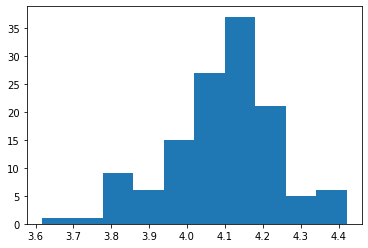

In [11]:
from utils import check_grads

batch = next(ds.__iter__())
check_grads(model, batch, plot_wandb=False, condense=False)

In [38]:
from tensorflow.keras.layers import Dense

num_classes = 10
classifier = Dense(num_classes)
opt_classifier = tf.keras.optimizers.Adam(learning_rate=1e-3)
_ = classifier(model(batch, training=True))

In [39]:
ds_classifier = tf.data.Dataset.from_tensor_slices((x_train, y_train)).repeat().shuffle(buffer_size).batch(batch_size)

In [49]:
def train_classifier(classifier, model, opt, ds):
    losses = []
    accs = []
    with tqdm.tqdm(total=num_steps) as pb:
        for step, batch in zip(range(num_steps), ds):
            images, labels = batch
            with tf.GradientTape() as tape:
                z = model(images, training=True)
                logits = classifier(z, training=True)
                losses_elementwise = tf.nn.softmax_cross_entropy_with_logits(labels, logits)
                loss = tf.reduce_mean(losses_elementwise)
            preds = tf.argmax(logits, axis=-1)
            acc = tf.reduce_mean(tf.cast(preds == tf.argmax(labels, axis=-1), dtype=tf.float32)) * 100
            gradient = tape.gradient(loss, classifier.trainable_variables)
            opt.apply_gradients(zip(gradient, classifier.trainable_variables))
            losses.append(loss); accs.append(acc)
            pb.set_postfix(avg_loss=float(np.array(losses).mean()), loss=float(loss.numpy()),
                           avg_acc=float(np.array(accs).mean()), acc=float(acc.numpy()))
            pb.update()
train_classifier(classifier, model, opt_classifier, ds_classifier)

100%|██████████| 300/300 [00:26<00:00, 11.23it/s, acc=81.2, avg_acc=79.2, avg_loss=0.675, loss=0.564]


In [52]:
from tensorflow.keras.layers import Dense

num_classes = 10
classifier = Dense(num_classes)
opt_classifier = tf.keras.optimizers.Adam(learning_rate=1e-3)
_ = classifier(tf.reshape(batch, shape=(len(batch), 784)))
def train_classifier(classifier, model, opt, ds):
    losses = []
    accs = []
    with tqdm.tqdm(total=num_steps) as pb:
        for step, batch in zip(range(1000), ds):
            images, labels = batch
            with tf.GradientTape() as tape:
                z = tf.reshape(images, shape=(len(images), 784))
                logits = classifier(z, training=True)
                losses_elementwise = tf.nn.softmax_cross_entropy_with_logits(labels, logits)
                loss = tf.reduce_mean(losses_elementwise)
            preds = tf.argmax(logits, axis=-1)
            acc = tf.reduce_mean(tf.cast(preds == tf.argmax(labels, axis=-1), dtype=tf.float32)) * 100
            gradient = tape.gradient(loss, classifier.trainable_variables)
            opt.apply_gradients(zip(gradient, classifier.trainable_variables))
            losses.append(loss); accs.append(acc)
            pb.set_postfix(avg_loss=float(np.array(losses).mean()), loss=float(loss.numpy()),
                           avg_acc=float(np.array(accs).mean()), acc=float(acc.numpy()))
            pb.update()
train_classifier(classifier, model, opt_classifier, ds_classifier)

1000it [00:09, 110.17it/s, acc=92.2, avg_acc=88.4, avg_loss=0.394, loss=0.278]                        
